# Krafthack March 7-8 2022
**Team: Data Liberators**  
- Andris Piebalgs
- Hayden Hohns
- Simon Stavland

Requirements:
* Install all required packages with poetry `poetry install`
* All data must be store locally in parent folder under `data`

Summary:
* Import and preprocess data for machine learning
* Train a machine learning model to predict the strain on 6 different bolts
* Several regression models have been considered such as Linear and Random Forest Regression.
* Good MAPE (Mean Absolute Error Percentage) score forlinear model with graphical validation
* Use the chosen model to predict future strain rates

# Importing python libraries

In [1]:
import os
import time

from dataclasses import dataclass
from functools import wraps
from typing import Any, Callable

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
from xgboost.sklearn import XGBRegressor

%matplotlib inline

/home/keepfloyding/.env/lib64/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Loading dataset

In [2]:
# datasets are stored in the data folder
data_dir = os.path.join("..","data")
dataset_2 = os.path.join(data_dir,"input_dataset-2.parquet")
bolt_pretension_file = os.path.join("bolt_pretension.csv")
prediction_input_file = os.path.join(data_dir,"prediction_input.parquet")
# dataset_1 = os.path.join(data_dir,"input_dataset-1.parquet")  # commented out because it is very large

# validation data
validation_raw = pd.read_parquet(prediction_input_file)
training_data_2 = pd.read_parquet(dataset_2)
# training_data_1 = pd.read_parquet(dataset_1)  # commented out because it is very large

# features are found from the validation set
feature_names = list(validation_raw.columns)

# dataset 2 contains the training data:
x_raw = training_data_2[feature_names]
target_vars = training_data_2.filter(regex="Tensile")


# Preprocessing and feature engineering

In [14]:
# functions for preprocessing pipeline

def log_df_pipe(f: Callable):
    """
    Decorator for logging functions handling dataframes
    Can be applied to functions where a dataframe is the input and output
    Typically functions used with df.pipe(f, *args)
    """
    @wraps(f)
    def wrapper(df, *args, **kwargs):
        start = time.time()
        result = f(df, *args, **kwargs)
        elapsed_time = time.time() - start
        print(f"{f.__name__} took {elapsed_time} seconds")
        print(f"Dataframe shape: {result.shape}")
        print(f"NA in dataframe: {result.isna().sum().sum()}")
        return result

    return wrapper

@log_df_pipe
def copy_df(df:pd.DataFrame):
    return df.copy()

@log_df_pipe
def mode_to_numerical(df: pd.DataFrame):
    df.loc[:, "mode"] = (df["mode"]=="operation").astype(float)
    return df

@log_df_pipe
def drop_na(df: pd.DataFrame):
    return df.dropna(axis=0)


@log_df_pipe
def add_seasonality_features(df: pd.DataFrame) -> pd.DataFrame:
    """Perform pre-processing of data.

    Args:
        df (pd.DataFrame): Dataframe that contains a valid index (datetime).

    Returns:
        pd.DataFrame: Same input dataframe but with extra columns.
    """
    df["month"] = df.index.month
    df["day"] = df.index.day
    # heavy rain: september-november, snow: december-march, melting: april-june, dry: july-august
    # Snow = 1, Melting = 2, Dry = 3, Rain = 4
    seasons = {
        1: 1, 2: 1, 3: 1, 
        4: 2, 5: 2, 6: 2,
        7: 3, 8: 3,
        9: 4, 10: 4, 11: 4,
        12: 1
    }
    df["season"] = df["month"].map(seasons)
    df["time"] = [item.value/1e9 for item in df.index]
    return df

def permissible_stress(
    pressure: pd.Series,
    penstock_diameter: float=2.2,
    penstock_thickness: float = 54e-3,
    efficiency: float = 0.8,
) -> float:
    return pressure * penstock_diameter / (2 * penstock_thickness * efficiency)


@log_df_pipe
def time_since_operation_ended(df: pd.DataFrame):
    df["mode_difference"] = df["mode"] - df["mode"].shift(-1)
    df["time_difference"] = df.index - df.index.shift(-1, freq="S")
    time_since = []
    time = 0.0
    for _, row in df.iterrows():
        if row["mode_difference"] > 0:
            time = 0.0
            time_since.append(time)
        else:
            time += row["time_difference"].seconds
            time_since.append(time)
    df["time_since"] = time_since
    return df

@log_df_pipe
def turbine_deficit_stress(df: pd.DataFrame):
    df["stress_deficit_turbine"] = 3000 - permissible_stress(pressure=df["Turbine_Pressure Drafttube"])
    return df


@log_df_pipe
def select_features(df:pd.DataFrame):
    return df[[
        "Unit_4_Power",
        "Unit_4_Reactive Power",
        "Turbine_Guide Vane Opening",
        "Turbine_Pressure Drafttube",
        "Turbine_Pressure Spiral Casing",
        "Turbine_Rotational Speed",
        "season",
        "month",
        "time",
        "stress_deficit_turbine",
        "time_since",
    ]]


In [18]:
x = (
    x_raw.pipe(copy_df)
    .pipe(drop_na)
    .pipe(mode_to_numerical)
    .pipe(add_seasonality_features)
    .pipe(time_since_operation_ended)
    .pipe(turbine_deficit_stress)
    .pipe(select_features)

)
x_baseline = (
    x_raw.pipe(copy_df)
    .pipe(drop_na)
    .pipe(mode_to_numerical)

)

validation = (
    validation_raw.pipe(copy_df)
    .pipe(drop_na)
    .pipe(mode_to_numerical)
    .pipe(add_seasonality_features)
    .pipe(time_since_operation_ended)
    .pipe(turbine_deficit_stress)
    .pipe(select_features)
)

copy_df took 0.025946617126464844 seconds
Dataframe shape: (1874087, 7)
NA in dataframe: 744522
drop_na took 0.27341747283935547 seconds
Dataframe shape: (1750000, 7)
NA in dataframe: 0
mode_to_numerical took 0.08979511260986328 seconds
Dataframe shape: (1750000, 7)
NA in dataframe: 0
add_seasonality_features took 4.258904933929443 seconds
Dataframe shape: (1750000, 11)
NA in dataframe: 0
time_since_operation_ended took 91.67828226089478 seconds
Dataframe shape: (1750000, 14)
NA in dataframe: 1
turbine_deficit_stress took 0.010242700576782227 seconds
Dataframe shape: (1750000, 15)
NA in dataframe: 1
select_features took 0.09157395362854004 seconds
Dataframe shape: (1750000, 11)
NA in dataframe: 0
copy_df took 0.02801680564880371 seconds
Dataframe shape: (1874087, 7)
NA in dataframe: 744522
drop_na took 0.3450801372528076 seconds
Dataframe shape: (1750000, 7)
NA in dataframe: 0
mode_to_numerical took 0.1391923427581787 seconds
Dataframe shape: (1750000, 7)
NA in dataframe: 0
copy_df too

### Ensure that nans are removed for target variables too

In [20]:
# Drop nans in target data
def drop_target_nans(targets_df, train_raw_df):
    is_nan_row = train_raw_df.isna().any(axis=1)
    targets_df = targets_df[~is_nan_row]
    return targets_df

In [21]:
targets_df = (
    target_vars.pipe(copy_df)
    .pipe(drop_target_nans, x_raw )
)

copy_df took 0.027152299880981445 seconds
Dataframe shape: (1874087, 6)
NA in dataframe: 744522


In [22]:
assert targets_df.shape[0] == x.shape[0]

# Build ML model

In [8]:
# container for model response
@dataclass
class ModelResponse:
    bolt_name: str
    model: Any
    scaler: Any
    train_mape: float
    test_mape: float
    y_test: Any
    y_pred: Any

In [9]:
def train_bolts_models(train_df, targets_df, model=LinearRegression, model_kwargs = None):
    if model_kwargs is None:
        model_kwargs = {}
        
    res = {}
    
    # Iterate through each target (i.e. each bolt)
    for target_name, target_data in targets_df.iteritems():
        
        print(f"Started training {target_name}")
        
        X_train, X_test = np.split(train_df, [int(.4 *len(train_df))])
        y_train, y_test = np.split(target_data, [int(.4 *len(target_data))])
        
        # Create cross validation pipeline
        scoring = {'mean_absolute_percentage_error': make_scorer(mean_absolute_percentage_error)}
        scaler = StandardScaler()
        m = model(**model_kwargs)
        pipe = Pipeline([('scaler', scaler), ('clf', m)])
        pipe.fit(X_train, y_train)
        
        # Get the mean scores for test and training
        y_pred_test = pipe.predict(X_test)
        train_mape = mean_absolute_percentage_error(y_train, pipe.predict(X_train))
        test_mape = mean_absolute_percentage_error(y_test,y_pred_test)
                
        # save to output dict
        res[target_name] = ModelResponse(bolt_name=target_name, model = m, scaler=scaler, train_mape=train_mape, test_mape=test_mape, y_test=y_test, y_pred=y_pred_test)

        print(f"Finished training {target_name}")
    return res

In [10]:
def plot_results(model_res):
    fig, axs = plt.subplots(6, figsize=(15, 30))
    for i, model_response in enumerate(model_res.values()):
        y_test = model_response.y_test
        y_pred = model_response.y_pred
        axs[i].plot(range(1400,1800), range(1400, 1800))
        axs[i].plot(y_test, y_pred, "o")
        axs[i].set_title(model_response.bolt_name)
        axs[i].set(xlabel="y_test", ylabel="y_pred")

# Baseline model: linear regression

In [11]:
linear_res = train_bolts_models(x_baseline, targets_df)

Started training Bolt_1_Tensile
Finished training Bolt_1_Tensile
Started training Bolt_2_Tensile
Finished training Bolt_2_Tensile
Started training Bolt_3_Tensile
Finished training Bolt_3_Tensile
Started training Bolt_4_Tensile
Finished training Bolt_4_Tensile
Started training Bolt_5_Tensile
Finished training Bolt_5_Tensile
Started training Bolt_6_Tensile
Finished training Bolt_6_Tensile


In [12]:
for response in linear_res.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

train mape: 0.0005555556308020109, test mape: 0.009430944611465732
train mape: 0.0003749974339464169, test mape: 0.0064312071276194085
train mape: 0.00017174596856188757, test mape: 0.0043749975654015175
train mape: 0.00011503614557377184, test mape: 0.0008250728634758007
train mape: 9.282928461177881e-05, test mape: 0.0006537622394948721
train mape: 0.00012057747494532224, test mape: 0.003418068459401597


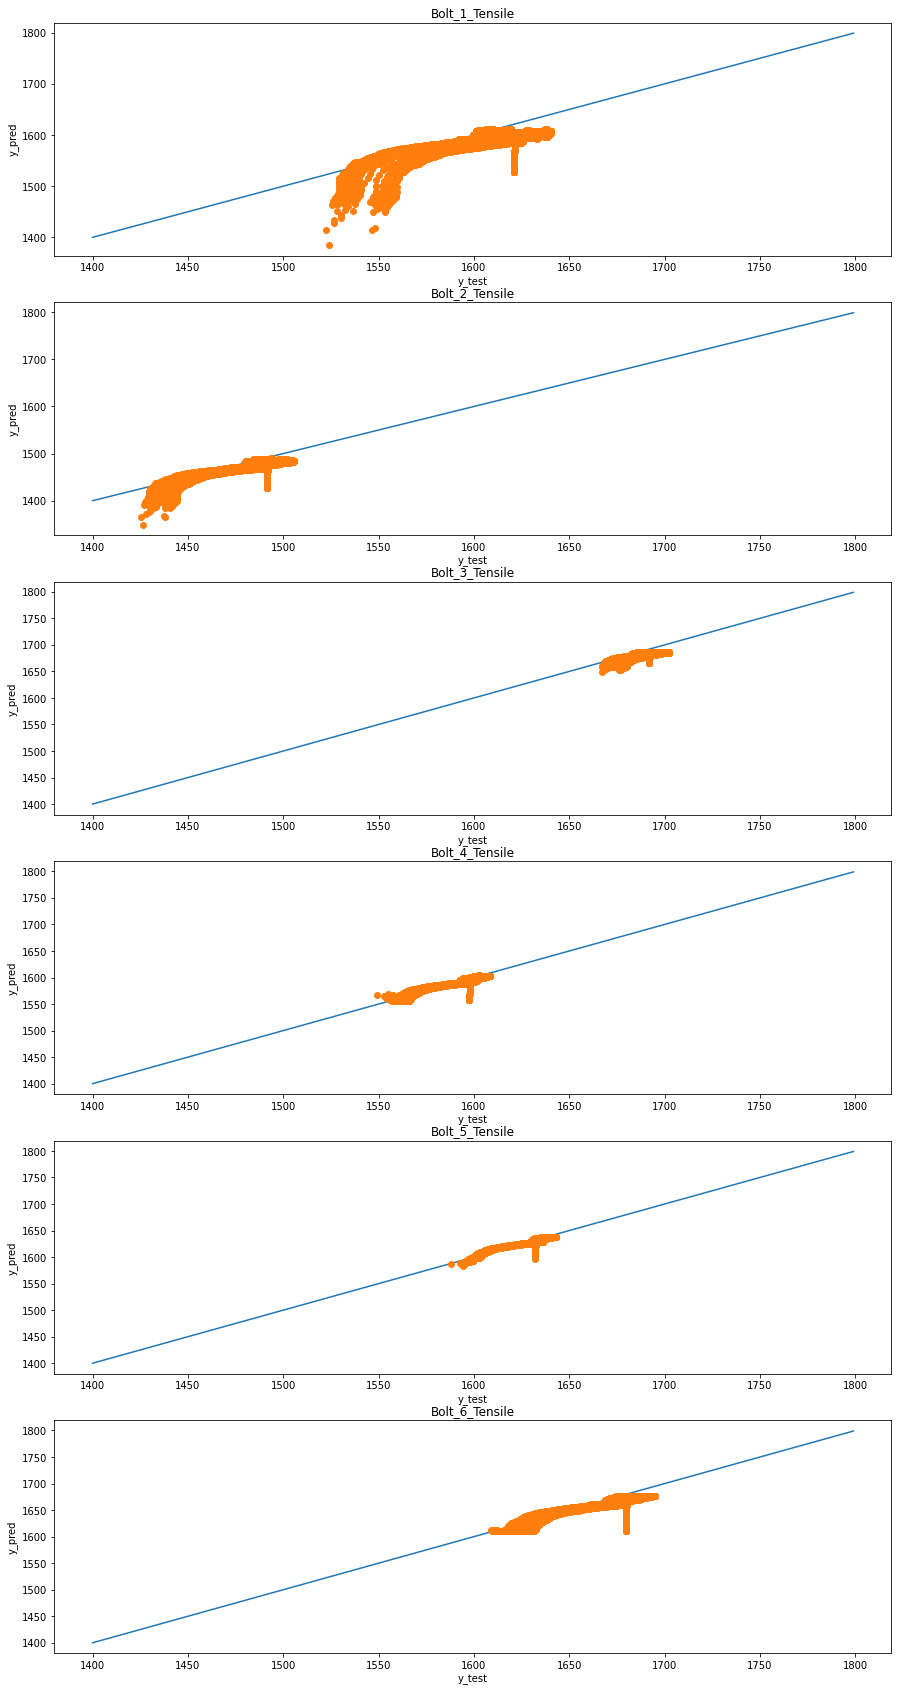

In [13]:
plot_results(linear_res)

# Linear regression with improved features

In [14]:
linear_res_feat_eng = train_bolts_models(x, targets_df)

Started training Bolt_1_Tensile
Finished training Bolt_1_Tensile
Started training Bolt_2_Tensile
Finished training Bolt_2_Tensile
Started training Bolt_3_Tensile
Finished training Bolt_3_Tensile
Started training Bolt_4_Tensile
Finished training Bolt_4_Tensile
Started training Bolt_5_Tensile
Finished training Bolt_5_Tensile
Started training Bolt_6_Tensile
Finished training Bolt_6_Tensile


In [15]:
for response in linear_res_feat_eng.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

train mape: 0.0001274365528210395, test mape: 0.0015373693521007594
train mape: 0.000102723563509448, test mape: 0.001169905295372952
train mape: 8.787652315594827e-05, test mape: 0.002173465907776618
train mape: 9.233461134378271e-05, test mape: 0.0016228950238196087
train mape: 8.932972097899805e-05, test mape: 0.0009452816493133555
train mape: 0.00010933919999785792, test mape: 0.0028259420646088375


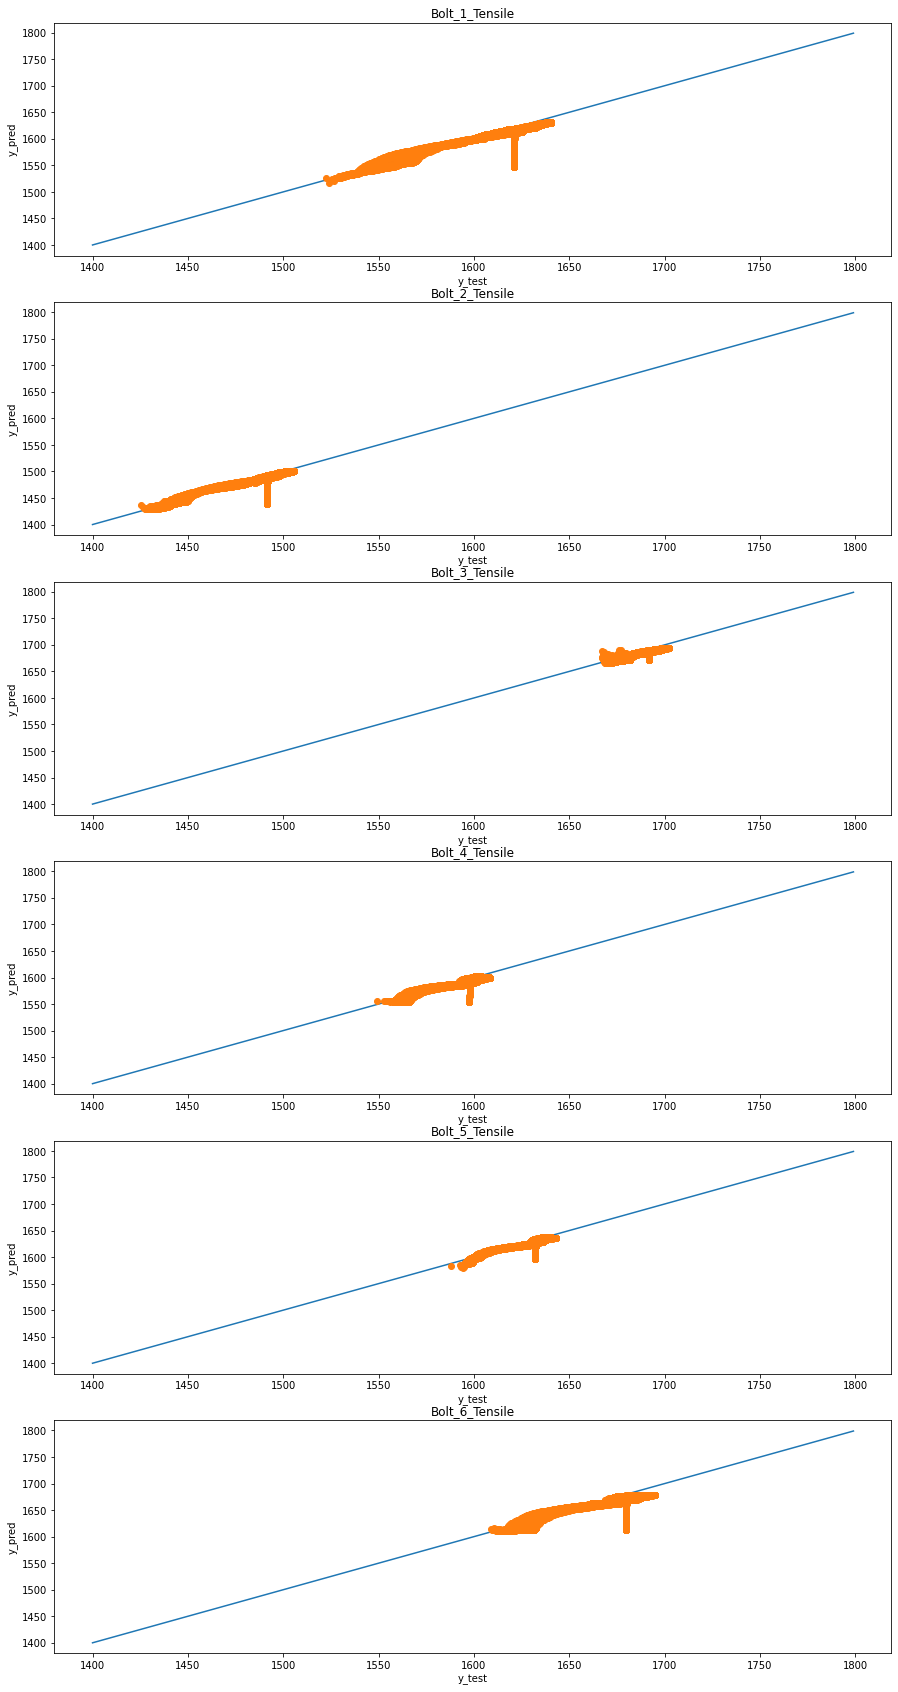

In [16]:
plot_results(linear_res_feat_eng)

# Non linear ML Model: Random Forrest regression

In [17]:
nonlinear_res = train_bolts_models(x, targets_df, model=RandomForestRegressor, model_kwargs = {"n_estimators":20, "max_depth": 4})

Started training Bolt_1_Tensile
Finished training Bolt_1_Tensile
Started training Bolt_2_Tensile
Finished training Bolt_2_Tensile
Started training Bolt_3_Tensile
Finished training Bolt_3_Tensile
Started training Bolt_4_Tensile
Finished training Bolt_4_Tensile
Started training Bolt_5_Tensile
Finished training Bolt_5_Tensile
Started training Bolt_6_Tensile
Finished training Bolt_6_Tensile


In [18]:
for response in nonlinear_res.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

train mape: 0.00014203121379718588, test mape: 0.008478093812933544
train mape: 0.00016028527825607874, test mape: 0.005850786605697834
train mape: 8.501735810722979e-05, test mape: 0.0041339745898293445
train mape: 6.65034409977096e-05, test mape: 0.0009254487224749566
train mape: 6.130979710961302e-05, test mape: 0.0008031348161128772
train mape: 9.023193929677844e-05, test mape: 0.0033640608975258977


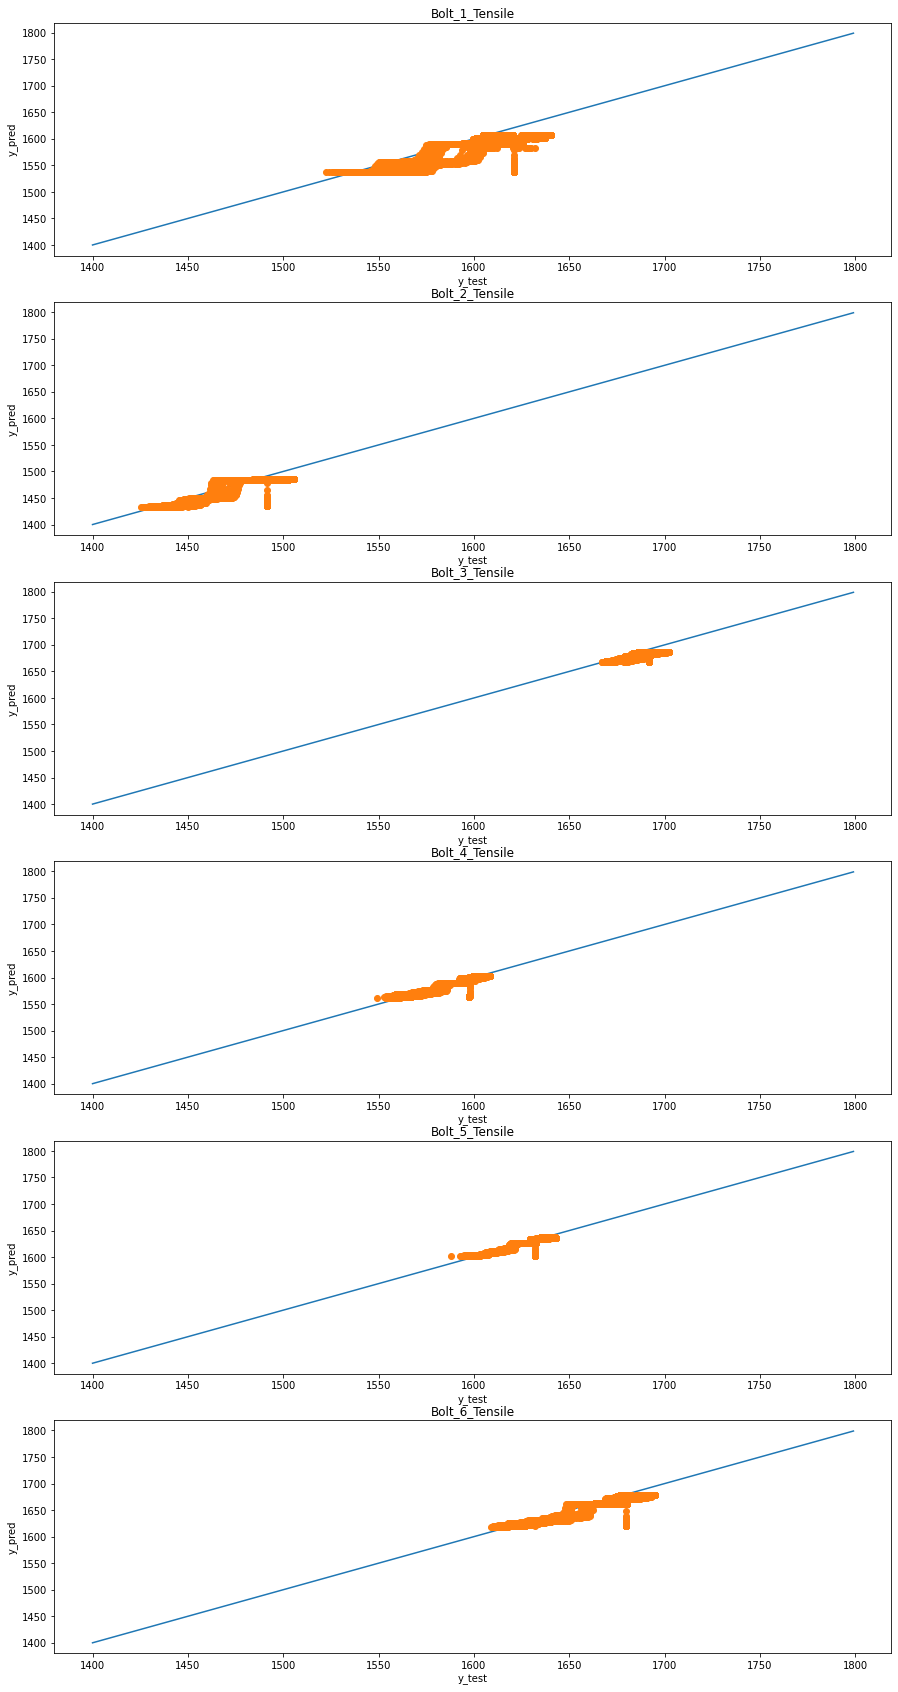

In [19]:
plot_results(nonlinear_res)

# Non linear ML model: Xgboost

In [20]:
nonlinear_xgb_res = train_bolts_models(x, targets_df, model=XGBRegressor, model_kwargs = {"n_estimators":80, "max_depth": 3})

Started training Bolt_1_Tensile
Finished training Bolt_1_Tensile
Started training Bolt_2_Tensile
Finished training Bolt_2_Tensile
Started training Bolt_3_Tensile
Finished training Bolt_3_Tensile
Started training Bolt_4_Tensile
Finished training Bolt_4_Tensile
Started training Bolt_5_Tensile
Finished training Bolt_5_Tensile
Started training Bolt_6_Tensile
Finished training Bolt_6_Tensile


In [21]:
for response in nonlinear_res.values():
    print(f"train mape: {response.train_mape}, test mape: {response.test_mape}")

train mape: 0.00014203121379718588, test mape: 0.008478093812933544
train mape: 0.00016028527825607874, test mape: 0.005850786605697834
train mape: 8.501735810722979e-05, test mape: 0.0041339745898293445
train mape: 6.65034409977096e-05, test mape: 0.0009254487224749566
train mape: 6.130979710961302e-05, test mape: 0.0008031348161128772
train mape: 9.023193929677844e-05, test mape: 0.0033640608975258977


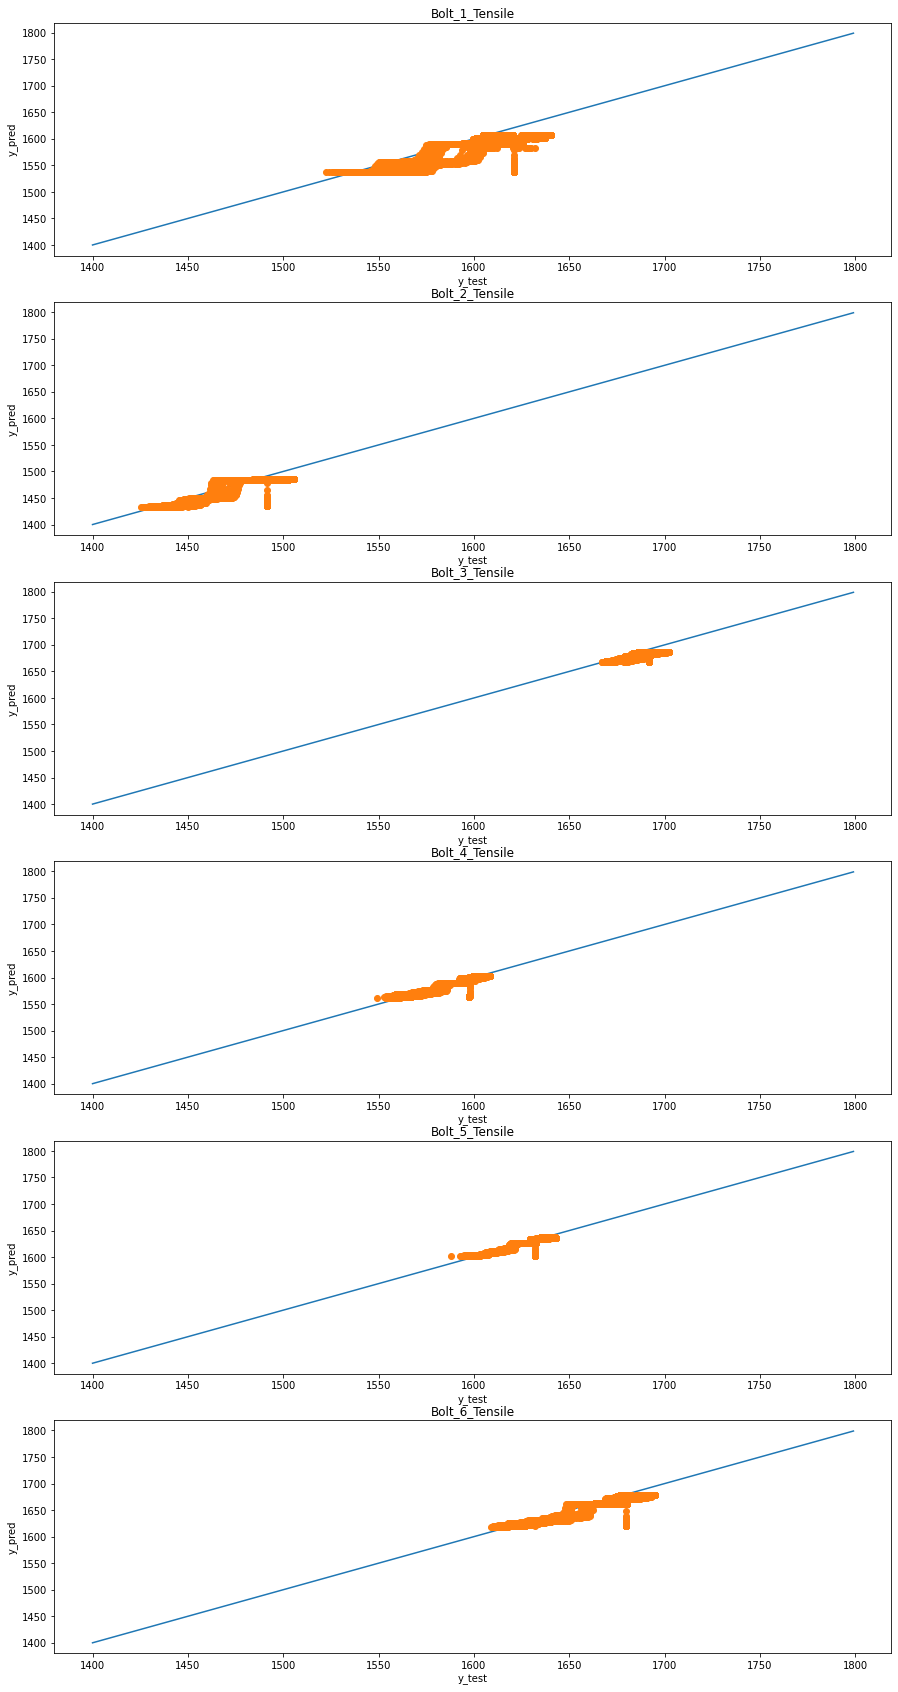

In [22]:
plot_results(nonlinear_res)

# Export csv file with predictions

Use linear regression with improved features

In [23]:
model = LinearRegression()

store=[]
for target_name, target_data in targets_df.iteritems():
    
    print(f'Training {target_name}...')
    
    scaler = StandardScaler()
    pipe = Pipeline([('scaler', scaler), ('clf', model)])
    pipe.fit(x, target_data)
    y_pred = pipe.predict(validation)
    
    res = pd.Series(y_pred, index=validation.index, name=target_name)
    store.append(res)

    
predictions_df = pd.concat(store,axis=1)

csv_export_filename = "bolt_tensile_predictions.csv"
predictions_df.to_csv(csv_export_filename)

Training Bolt_1_Tensile...
Training Bolt_2_Tensile...
Training Bolt_3_Tensile...
Training Bolt_4_Tensile...
Training Bolt_5_Tensile...
Training Bolt_6_Tensile...


# Predicting end of life

Use our models to predict end of life for each bolt. 

In [36]:
# Look forward to the year 18 years from next year with a month frequency
df_pred = pd.DataFrame(index=pd.date_range(start='1972-01-01', end='1990',freq='1M'))


# Grab last 500 rows of data and use the means as forward projections in time
tmp = x_raw.tail(500).mean()

for col,item in zip(tmp.index,tmp):
    df_pred[col] = item
    
df_pred['mode']='operation'

/tmp/ipykernel_144530/3064330295.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  tmp = x_raw.tail(500).mean()


In [38]:
x_pred = (
    df_pred.pipe(copy_df)
    .pipe(drop_na)
    .pipe(mode_to_numerical)
    .pipe(add_seasonality_features)
    .pipe(time_since_operation_ended)
    .pipe(turbine_deficit_stress)
    .pipe(select_features)

)

copy_df took 0.00074005126953125 seconds
Dataframe shape: (216, 7)
NA in dataframe: 0
drop_na took 0.00124359130859375 seconds
Dataframe shape: (216, 7)
NA in dataframe: 0
mode_to_numerical took 0.0011029243469238281 seconds
Dataframe shape: (216, 7)
NA in dataframe: 0
add_seasonality_features took 0.004288673400878906 seconds
Dataframe shape: (216, 11)
NA in dataframe: 0
time_since_operation_ended took 0.016616106033325195 seconds
Dataframe shape: (216, 14)
NA in dataframe: 1
turbine_deficit_stress took 0.0007169246673583984 seconds
Dataframe shape: (216, 15)
NA in dataframe: 1
select_features took 0.0010190010070800781 seconds
Dataframe shape: (216, 11)
NA in dataframe: 0


In [39]:
model = LinearRegression()


store=[]
for target_name, target_data in targets_df.iteritems():
    
    print(f'Training {target_name}...')
    
    scaler = StandardScaler()
    pipe = Pipeline([('scaler', scaler), ('clf', model)])
    pipe.fit(x, target_data)
    y_pred = pipe.predict(x_pred)
    res = pd.Series(y_pred, index=x_pred.index, name=target_name)
    store.append(res)

predictions_df = pd.concat(store,axis=1)

predictions_df.head()
    
    

Training Bolt_1_Tensile...
Training Bolt_2_Tensile...
Training Bolt_3_Tensile...
Training Bolt_4_Tensile...
Training Bolt_5_Tensile...
Training Bolt_6_Tensile...


,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
1972-01-31,2021.914325,1712.125891,1842.919575,1670.366190,1690.751852,1829.266565
1972-02-29,2052.156005,1728.387911,1853.995511,1675.520932,1694.855364,1840.279972
1972-03-31,2084.474270,1745.773336,1865.841582,1681.018466,1699.230449,1852.048359
1972-04-30,2115.754243,1762.597059,1877.302586,1686.344604,1703.469747,1863.439257
1972-05-31,2148.072508,1779.982484,1889.148658,1691.842138,1707.844833,1875.207644


Text(0.5, 1.0, 'Predictions for tensile. Today is 1971-01-25 11:06:48')

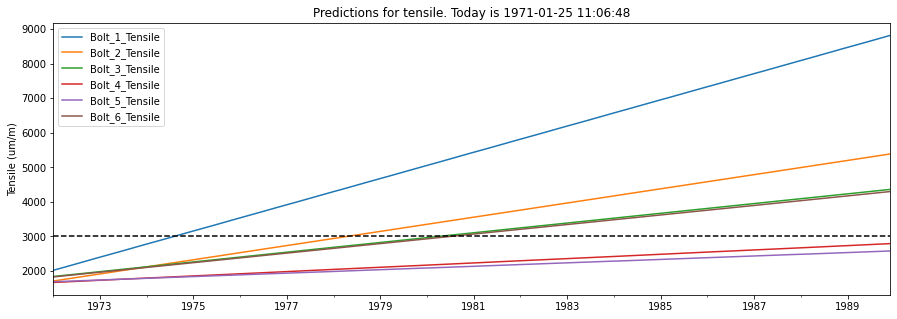

In [72]:
# Plot (threshold is 3000)
predictions_df.plot(figsize=(15,5))
plt.axhline(3000, color='k', linestyle='--')
plt.ylabel('Tensile (um/m)')

plt.title(f'Predictions for tensile. Today is {x.index[-1]}')

In [68]:
# Check for end of life predictions
print(f'Today is {x.index[-1]}')
for col in predictions_df:
    
    tmp = predictions_df[predictions_df[col]>3000]
    if len(tmp)>0:
        print(col, ' fails at ',tmp.index[0])


Today is 1971-01-25 11:06:48
Bolt_1_Tensile  fails at  1974-08-31 00:00:00
Bolt_2_Tensile  fails at  1978-05-31 00:00:00
Bolt_3_Tensile  fails at  1980-04-30 00:00:00
Bolt_6_Tensile  fails at  1980-07-31 00:00:00
